## library load

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import cdist
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans

%matplotlib inline
plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["font.size"] = 15
plt.rcParams["figure.figsize"] = (16,9)
plt.rcParams["axes.unicode_minus"] = False
plt.style.use("ggplot")

pd.set_option("display.max_rows", 10)
pd.set_option("display.max_columns", 10)

## data load

In [2]:
# rnch load
df_cust = pd.read_csv("../LPOINT_BIG_COMP/LPOINT_BIG_COMP_01_DEMO.csv")
df_pdde = pd.read_csv("../LPOINT_BIG_COMP/LPOINT_BIG_COMP_02_PDDE.csv")
df_cop_u = pd.read_csv("../LPOINT_BIG_COMP/LPOINT_BIG_COMP_03_COP_U.csv")
df_pd_clac = pd.read_csv("../LPOINT_BIG_COMP/LPOINT_BIG_COMP_04_PD_CLAC.csv")

C:\Users\yunjc\AppData\Local\Temp\ipykernel_10452\1110954637.py:3: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_pdde = pd.read_csv("../LPOINT_BIG_COMP/LPOINT_BIG_COMP_02_PDDE.csv")


In [3]:
# ## osy load
# df_cust = pd.read_csv("../../LPOINT_BIG_COMP_01_DEMO.csv")
# df_pdde = pd.read_csv("../../LPOINT_BIG_COMP_02_PDDE.csv")
# df_cop_u = pd.read_csv("../../LPOINT_BIG_COMP_03_COP_U.csv")
# df_pd_clac = pd.read_csv("../../LPOINT_BIG_COMP_04_PD_CLAC.csv")

In [4]:
## choongs load
# df_cust = pd.read_csv("../../LPOINT_BIG_COMP/LPOINT_BIG_COMP_01_DEMO.csv")
# df_pdde = pd.read_csv("../../LPOINT_BIG_COMP/LPOINT_BIG_COMP_02_PDDE.csv")
# df_cop_u = pd.read_csv("../../LPOINT_BIG_COMP/LPOINT_BIG_COMP_03_COP_U.csv")
# df_pd_clac = pd.read_csv("../../LPOINT_BIG_COMP/LPOINT_BIG_COMP_04_PD_CLAC.csv")

## Function

In [5]:
#DBSCAN을 통해 이상치 제거
def delete_outlier_DBSCAN(df_pdde, df_pd_clac):
    df_pdde_pd_clac = df_pdde.merge(df_pd_clac, how='left', on='pd_c')
    df_pt = pd.pivot_table(data=df_pdde_pd_clac,
               values='buy_am',
               index='cust',
               columns='clac_hlv_nm',
               aggfunc='sum',
               fill_value=0)

    df_pt.reset_index(inplace=True)

    scaler = MinMaxScaler()
    scaler.fit(df_pt.iloc[:,1:])
    df_spt = pd.DataFrame(scaler.transform(df_pt.iloc[:,1:]), index=df_pt["cust"], columns=df_pt.columns[1:])
    df_spt_2 =  df_spt.reset_index()

    dbscan = DBSCAN(eps = 0.1, min_samples = 30, metric = "euclidean")
    dbscan_labels = dbscan.fit_predict(df_spt_2.iloc[:, 1:])
    df_spt_2['outlier'] = dbscan_labels

    df_spt_not_outlier_cust = df_spt_2[df_spt_2['outlier']==0]['cust']
    
    return df_spt_not_outlier_cust



# 누락 데이터 삭제
def check_on_off(df_main, df, key="cust", col_nm="chnl_dv"):
    df_new = pd.DataFrame(df.groupby(key)[col_nm].apply(lambda x:list(set(x))))
    return df_main.merge(df_new, how="left", on=key).dropna(subset=["chnl_dv"])



# on/off 분류
def split_on_off(df, col_nm="chnl_dv"):
    df[col_nm] = df[col_nm].apply(lambda x: x[0] if len(x)==1 else 0)
    df_off = df.loc[df[col_nm]==1] ##off
    df_on = df.loc[df[col_nm]==2] ##on
    df_onf = df.loc[df[col_nm]==0] ##onf

    df_not_off = pd.concat([df_on, df_onf], axis=0, ignore_index=True)


    return df_off, df_not_off #off, not_off

def classification_buy_am(x, std_points):
    if x <= std_points[0]:
        return "D"
    elif std_points[0] < x <= std_points[1]:
        return "C"
    elif std_points[1] < x <= std_points[2]:
        return "B"
    else:
        return "A"

def split_buy_amount_by_4(df_main, df_sub, key='cust', col_nm='buy_am'):
    df_new = df_sub.groupby([key], as_index=False)[col_nm].sum()
    df_new2 = df_main.merge(df_new, on='cust', how='left')
    df_new2["am_class"] = df_new2[col_nm].apply(classification_buy_am, std_points=np.quantile(df_new2[col_nm], [.25, .5, .75]))
    

    df_A = df_new2[df_new2['am_class']=='A']
    df_B = df_new2[df_new2['am_class']=='B']
    df_C = df_new2[df_new2['am_class']=='C']
    df_D = df_new2[df_new2['am_class']=='D']
    
    return df_A, df_B, df_C, df_D
    

def domain_clustering_ver2(df_main, df_sub, df_sub2):

    not_outlier_cust = delete_outlier_DBSCAN(df_sub, df_sub2)

    df_main = df_main.loc[df_main['cust'].isin(not_outlier_cust.values.tolist())]

    df = check_on_off(df_main, df_sub)

    df_off, df_not_off= split_on_off(df)

    
    df_off_A, df_off_B, df_off_C, df_off_D  = split_buy_amount_by_4(df_off, df_sub)
    df_not_off_A, df_not_off_B, df_not_off_C, df_not_off_D  = split_buy_amount_by_4(df_not_off, df_sub)

    df_off_A['cluster'] = 0
    df_off_B['cluster'] = 1
    df_off_C['cluster'] = 2
    df_off_D['cluster'] = 3
    df_not_off_A['cluster'] = 4
    df_not_off_B['cluster'] = 5
    df_not_off_C['cluster'] = 6
    df_not_off_D['cluster'] = 7

    df_off_A_label = df_off_A[['cust', 'cluster']]
    df_off_B_label = df_off_B[['cust', 'cluster']]
    df_off_C_label = df_off_C[['cust', 'cluster']]
    df_off_D_label = df_off_D[['cust', 'cluster']]
    df_not_off_A_label = df_not_off_A[['cust', 'cluster']]
    df_not_off_B_label = df_not_off_B[['cust', 'cluster']]
    df_not_off_C_label = df_not_off_C[['cust', 'cluster']]
    df_not_off_D_label = df_not_off_D[['cust', 'cluster']]
    

        
    return df_off_A_label, df_off_B_label, df_off_C_label, df_off_D_label, df_not_off_A_label, df_not_off_B_label, df_not_off_C_label, df_not_off_D_label

## Result of 8 clusters

In [6]:
df_off_A_label, df_off_B_label, df_off_C_label, df_off_D_label, df_not_off_A_label, df_not_off_B_label, df_not_off_C_label, df_not_off_D_label = domain_clustering_ver2(df_cust, df_pdde, df_pd_clac) 

result example

In [7]:
df_off_A_label

,cust,cluster
3,M000261625,0
4,M000350564,0
7,M000508243,0
24,M001694463,0
25,M001697472,0
...,...,...
16498,M998346579,0
16508,M999213998,0
16509,M999227380,0
16511,M999340261,0


* A > B > C > D (buy amount 순)

|군집 번호|채널   |금액 등급|고객 수|
|:------:|:-----:|:------:|:-----:|
|0       |Offline|A       |4129   |
|1       |Offline|B       |4129   |
|2       |Offline|C       |4129   |
|3       |Offline|D       |4130   |
|4       |Online |A       |2132   |
|5       |Online |B       |2131   |
|6       |Online |C       |2131   |
|7       |Online |D       |2132   |

# K means Clustering

In [8]:
### 아래 함수에서 각각의 데이터프레임 넣어서 각각에 대한 군집 뽑아내서 붙이려고 하나로 합치고 시작했슴당

df_list = [df_off_A_label, df_off_B_label, df_off_C_label, df_off_D_label, df_not_off_A_label, df_not_off_B_label, df_not_off_C_label, df_not_off_D_label]
df_dom_clustered = pd.concat(df_list, ignore_index=True)

In [9]:
df_main = pd.merge(df_pdde, df_pd_clac, how='left', on='pd_c')

In [20]:
def merging(df1, df2):
    return pd.merge(df1, df2, how='left', on='cust')


# def pivoting(df_main, df):
def pivoting(df_main, df):
    columns_default = list(df_main['clac_hlv_nm'].unique())
    df_res = pd.DataFrame(columns=columns_default)
    df_pt = pd.pivot_table(data=df,
                           values='buy_am',
                           index='cust',
                           columns='clac_hlv_nm',
                           aggfunc='sum',
                           fill_value=0)
    df_res = pd.concat([df_res, df_pt], ignore_index=False, axis=0)
    df_res.fillna(0, inplace=True)

    # scaler = MinMaxScaler()
    # scaler.fit(df_res)
    # df_spt = pd.DataFrame(scaler.transform(df_res), index=df_pt.indeㄴx, columns=df_res.columns)
    # return df_spt
    return df_res


### 추가한 부분 ###
def fit_scaler(df):
    scaler = MinMaxScaler()
    scaler.fit(df)
    return scaler

def transform_scaler(df, scaler):
    return pd.DataFrame(scaler.transform(df), index=df.index, columns=df.columns)
###################

def get_inertia(df, k):
    Kmeans = KMeans(n_clusters=k, random_state=200)
    Kmeans.fit(df)
    return Kmeans.inertia_

def get_clusters_k(df):
    k_range = range(2, 20)
    k_result = None

    for k in k_range:
        minus = get_inertia(df, k) - get_inertia(df, k + 1)
        if k == 2:
            minus_before = minus
            minus_rate_max = 0
        else:
            minus_rate = minus_before - minus
            if minus_rate > minus_rate_max:
                k_result = k
                minus_rate_max = minus_rate
            minus_before = minus

    return k_result


def clustering(df_main, df_dom_clustered):   ### 여기서 돌릴 때, 초기 데이터이면 fit만 하고, column명들 저장. 초기 데이터 아니면 다음으로 넘어가서 transform만
    df = merging(df_main, df_dom_clustered)
    
    ### 전체 스케일링 먼저 ###
    df_total_pt = pivoting(df, df)
    mms_scaler = fit_scaler(df_total_pt)
    ###
    
    df_result = pd.DataFrame()
    db_clustered_k = df_dom_clustered['cluster'].nunique()
    for i in range(db_clustered_k):
        df_ = df[df['cluster']==i]
        df_pt = pivoting(df_main, df_)
        
        ### 추가 라인 ###
        k = get_clusters_k(transform_scaler(df_pt, mms_scaler))
        ###
        
        # k = get_clusters_k(df_pt)
        Kmeans_ = KMeans(n_clusters=k, random_state=200)
        Kmeans_.fit(df_pt)
        cluster = Kmeans_.predict(df_pt)
        df_pt['buy_am_cluster'] = cluster
        df_result = pd.concat([df_result, df_pt])
        # break
    df_result.fillna(0, inplace=True)
    # df_result.reset_index(drop=False)
    df_result.reset_index(drop=False, inplace=True)
    df_result.rename({"index":"cust"}, axis=1, inplace=True)
    df_result = df_result.merge(df_dom_clustered, how="left", on="cust")
    df_clustered_final = df_result.loc[:, ['cust', 'buy_am_cluster', 'cluster']]
    
    return df_clustered_final

In [21]:
# df_total_pt = pivoting(df_main)
# mms_scaler = fit_scaler(df_total_pt)
# transform_scaler(df_total_pt, mms_scaler)
df_osy = clustering(df_main, df_dom_clustered)

In [22]:
df_osy

,cust,buy_am_cluster,cluster
0,M000261625,0,0
1,M000350564,4,0
2,M000508243,0,0
3,M001694463,0,0
4,M001697472,0,0
...,...,...,...
25038,M996376807,1,7
25039,M997082506,2,7
25040,M998129365,0,7
25041,M998600186,0,7


In [190]:
# df_osy.to_csv('../../result.csv', index=False)

In [23]:
comb_cluster = df_osy.iloc[:,1].astype(str)+df_osy.iloc[:,2].astype(str)
df_osy["comb_cluster"] = comb_cluster.apply(lambda x: comb_cluster.unique().tolist().index(x))
df_osy

,cust,buy_am_cluster,cluster,comb_cluster
0,M000261625,0,0,0
1,M000350564,4,0,1
2,M000508243,0,0,0
3,M001694463,0,0,0
4,M001697472,0,0,0
...,...,...,...,...
25038,M996376807,1,7,26
25039,M997082506,2,7,28
25040,M998129365,0,7,27
25041,M998600186,0,7,27


In [26]:
df_osy["comb_cluster"].value_counts()

11    3787
0     3543
8     2867
5     2605
26    1813
      ... 
17      71
3       65
24      60
4       16
18       8
Name: comb_cluster, Length: 29, dtype: int64

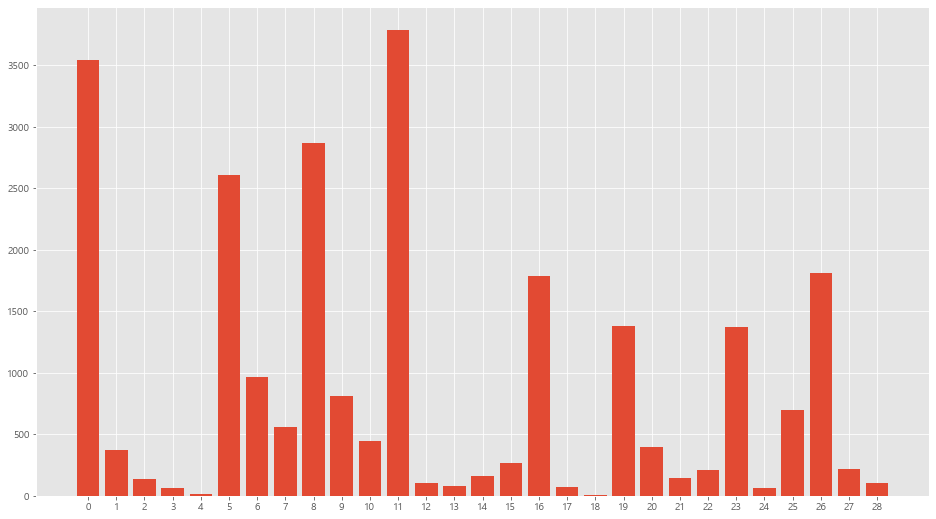

In [27]:
plt.bar(x=df_osy["comb_cluster"].value_counts().index, height=df_osy["comb_cluster"].value_counts().values)
plt.xticks([i for i in range(0,df_osy["comb_cluster"].nunique())])
plt.show()

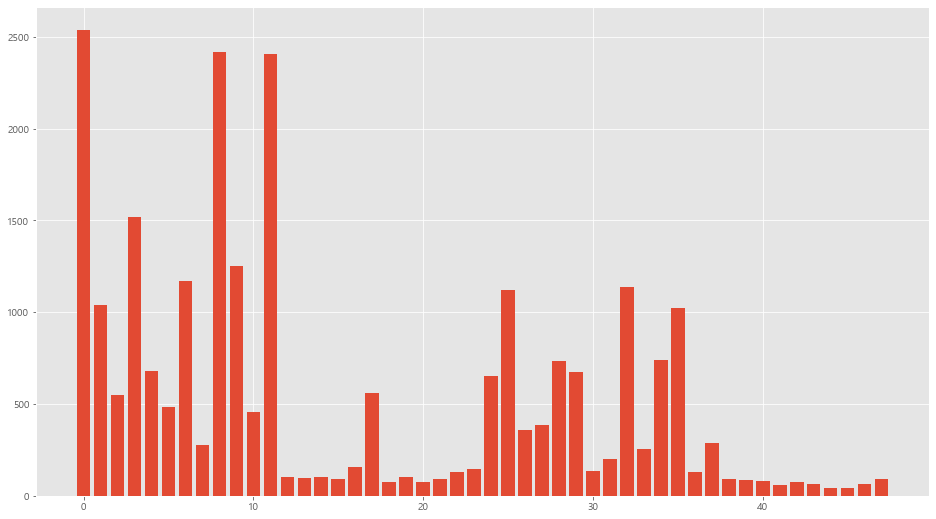

In [ ]:
#### 이전 결과 ####
plt.bar(x=df_osy["comb_cluster"].value_counts().index, height=df_osy["comb_cluster"].value_counts())
plt.show()

# 계층 군집화

In [26]:
df_samp = df_pdde.loc[df_pdde["cust"].isin(df_off_A_label["cust"].values)]
df_samp_pt = pd.pivot_table(data = df_samp,
                            index = "cust",
                            )

,cust,rct_no,chnl_dv,cop_c,br_c,pd_c,de_dt,de_hr,buy_am,buy_ct
0,M430112881,A01000001113,1,A01,A010039,PD0290,20210101,10,15000.0,1
2,M430112881,A01000003148,1,A01,A010039,PD0290,20210101,10,19000.0,1
3,M430112881,A01000003148,1,A01,A010039,PD0290,20210101,10,19000.0,1
4,M430112881,A01000004946,1,A01,A010039,PD0290,20210101,10,19000.0,1
5,M430112881,A01000005297,1,A01,A010039,PD1692,20210101,10,9900.0,1
...,...,...,...,...,...,...,...,...,...,...
4305554,M247832095,A05004776810,1,A05,A050298,PD0418,20211230,14,4000.0,1
4305557,M457920011,A05004779942,1,A05,A050157,PD0558,20211230,19,67900.0,1
4305567,M149105654,A05004783762,1,A05,A050039,PD0415,20211231,11,224900.0,1
4305575,M747846235,A05004790059,1,A05,A050318,PD1670,20211231,19,9900.0,1


In [28]:
# from sklearn.cluster import AgglomerativeClustering as AGC

# agc_cluster = AGC(n_clusters=3, affinity="cosine", linkage="average")
# agc_cluster.fit_predict(df_off_A_label)

()

# Find Neighbor

In [6]:
df_pdde_pd_clac = df_pdde.merge(df_pd_clac, how='left', on='pd_c')
df_pt = pd.pivot_table(data=df_pdde_pd_clac,
            values='buy_am',
            index='cust',
            columns='clac_hlv_nm',
            aggfunc='sum',
            fill_value=0)

df_pt.reset_index(inplace=True)

scaler = MinMaxScaler()
scaler.fit(df_pt.iloc[:,1:])
df_spt = pd.DataFrame(scaler.transform(df_pt.iloc[:,1:]), index=df_pt["cust"], columns=df_pt.columns[1:])
df_spt_2 =  df_spt.reset_index()
df_spt_2

clac_hlv_nm,cust,가구,건강식품,건강용품,건해산물,...,테넌트/음식점,패션잡화,퍼스널케어,헬스/피트니스,화장품/뷰티케어
0,M000034966,0.0,0.000000,0.000000,0.000813,...,0.000000,0.000000,0.000000,0.000000,0.000000
1,M000136117,0.0,0.000000,0.000000,0.000000,...,0.003625,0.013671,0.002099,0.015225,0.000888
2,M000201112,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000
3,M000225114,0.0,0.000000,0.000000,0.000000,...,0.012579,0.000914,0.000000,0.000000,0.001373
4,M000261625,0.0,0.000000,0.000000,0.000000,...,0.044248,0.000076,0.018588,0.000000,0.012273
...,...,...,...,...,...,...,...,...,...,...,...
26912,M999599111,0.0,0.001076,0.000000,0.001166,...,0.000000,0.000000,0.000000,0.000000,0.000000
26913,M999673157,0.0,0.000000,0.000000,0.000000,...,0.000873,0.004577,0.000000,0.000000,0.000493
26914,M999770689,0.0,0.006508,0.001428,0.000000,...,0.009315,0.000078,0.000000,0.000000,0.000000
26915,M999849895,0.0,0.000000,0.000246,0.000000,...,0.008162,0.000114,0.000000,0.000000,0.000000


In [7]:
df_0_log = df_spt_2.loc[df_spt_2['cust'].isin(df_off_A_label['cust'].values.tolist())]
df_0_log

clac_hlv_nm,cust,가구,건강식품,건강용품,건해산물,...,테넌트/음식점,패션잡화,퍼스널케어,헬스/피트니스,화장품/뷰티케어
4,M000261625,0.000000,0.000000,0.0,0.000000,...,0.044248,0.000076,0.018588,0.0,0.012273
5,M000350564,0.000307,0.017852,0.0,0.000000,...,0.001342,0.008809,0.000000,0.0,0.002372
9,M000508243,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000867,0.001175,0.0,0.000038
36,M001694463,0.000675,0.000000,0.0,0.006057,...,0.037817,0.000000,0.001681,0.0,0.000019
38,M001697472,0.000000,0.000000,0.0,0.000000,...,0.000000,0.006398,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
26881,M998346579,0.000000,0.000000,0.0,0.000582,...,0.015264,0.000000,0.000000,0.0,0.000000
26903,M999213998,0.000000,0.000000,0.0,0.007301,...,0.002953,0.000133,0.004143,0.0,0.001237
26904,M999227380,0.000000,0.000000,0.0,0.002686,...,0.018580,0.000979,0.000000,0.0,0.000077
26907,M999340261,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000


In [8]:
from scipy.spatial.distance import cdist

dist_map = cdist(df_0_log.iloc[:,1:], df_0_log.iloc[:,1:], metric='cosine')
dist_map_df = pd.DataFrame(dist_map, index=df_0_log["cust"], columns=df_0_log["cust"])
dist_map_df

temp_dict = dict()
for i in dist_map_df.index.tolist():
   temp_dict[i] = dist_map_df.loc[i,:].sort_values()[1:4].index.tolist()

df_cust_near = pd.DataFrame(temp_dict)
df_cust_near_result = df_cust_near.T
df_cust_near_result

,0,1,2
M000261625,M377275195,M241834190,M955329376
M000350564,M908934722,M409274346,M216947560
M000508243,M103616477,M557010626,M941739760
M001694463,M368322777,M565688203,M009541134
M001697472,M151347977,M721943730,M456856307
...,...,...,...
M998346579,M157272450,M416491629,M342338249
M999213998,M362833541,M210687594,M354931617
M999227380,M591198612,M516251891,M117163228
M999340261,M705698429,M820229067,M773895513


In [27]:
import copy

def code_to_name(df :pd.DataFrame, col_name :str, df_pdc :pd.DataFrame):
    df_result = copy.deepcopy(df)
    matching_series = df_pdc.set_index("pd_c")
    df_result[col_name] = df[col_name].apply(lambda x: matching_series.loc[x, "pd_nm"])
    return df_result

In [28]:
# sample은 이웃의 모든 구매 목록 리스트
sample = df_pdde.loc[df_pdde["cust"].isin(df_cust_near_result.loc["M000261625",:].tolist())]['pd_c'].value_counts()

# sample_result는 이웃의 모든 구매 목록 리스트와 Target(M000261625)의 구매 목록 리스트를 비교해 Target이 구매하지 않은 품목을 찾음
sample_result = set(sample.index)-set(df_pdde.loc[df_pdde['cust']=="M000261625"]['pd_c'].values)

# df_smp
df_smp = pd.DataFrame()
df_smp["neighbor_list"] = list(sample_result)
df_smp["neighbor_buy_am"] = list(map(lambda x: sample[x] ,list(sample_result)))
code_to_name(df_smp.sort_values("neighbor_buy_am", ascending=False), "neighbor_list", df_pd_clac)

,neighbor_list,neighbor_buy_am
25,여성티셔츠/탑,11
71,기타남성의류세트,9
64,임대매출,5
23,삶은나물류,4
19,냉동만두,4
...,...,...
1,페인트용품,1
42,감,1
43,기능성미,1
44,스포츠모자,1


# Association Rules about neighbors

연관 규칙 도출 Flow 함수화

In [29]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import *

def make_association_rule(df, order="rct_no", prod_code="pd_c", min_support=.003, min_confidence=.1):
    # 장바구니 별 상품 리스트
    product_list_per_order = df.groupby(order)[prod_code].apply(list)
    
    # 연관 규칙을 위한 encoding
    encoder = TransactionEncoder()
    one_hot_df = encoder.fit_transform(product_list_per_order)
    one_hot_df = pd.DataFrame(one_hot_df, columns=encoder.columns_)
    
    # 연관 규칙 도출
    frequent_item_df = apriori(one_hot_df, min_support=min_support)
    result = association_rules(frequent_item_df, metric="confidence", min_threshold=min_confidence)
    
    # 정리후 리턴
    result = result[["antecedents", "consequents", "support", "confidence"]].sort_values(by="confidence", ascending=False).reset_index(drop=True)
    result["antecedents"] = result["antecedents"].apply(lambda x: df.loc[df[prod_code]==one_hot_df.columns[list(x)[0]]][prod_code].values[0])
    result["consequents"] = result["consequents"].apply(lambda x: df.loc[df[prod_code]==one_hot_df.columns[list(x)[0]]][prod_code].values[0])

    return result

In [30]:
df_cust_near_result

,0,1,2
M000261625,M377275195,M241834190,M955329376
M000350564,M908934722,M409274346,M216947560
M000508243,M103616477,M557010626,M941739760
M001694463,M368322777,M565688203,M009541134
M001697472,M151347977,M721943730,M456856307
...,...,...,...
M998346579,M157272450,M416491629,M342338249
M999213998,M362833541,M210687594,M354931617
M999227380,M591198612,M516251891,M117163228
M999340261,M705698429,M820229067,M773895513
